In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

from trajectory import run_simulation_trajectory
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
n = 10000 # Starting plankton population size.
iters = 30 # Time steps.
L_max = 1 # Size of square domain.
colour_map = "hsv"

plankton_dict = run_simulation_trajectory(n, iters, L_max, False)

In [4]:
x = []
y = []
y0 = []
for id in plankton_dict:
    x.append(plankton_dict[id]['x'][-1])
    y.append(plankton_dict[id]['y'][-1])
    y0.append(plankton_dict[id]['y0'])

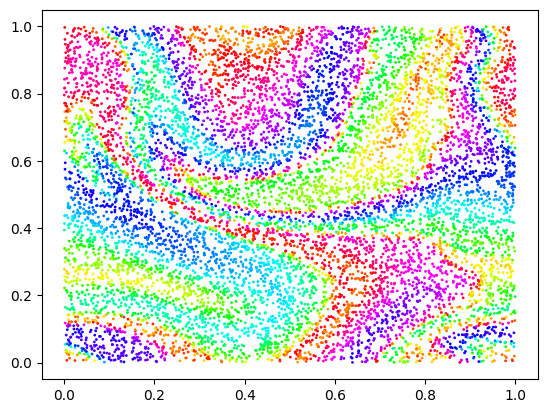

In [5]:
plt.scatter(x, y, c=y0, s=1, cmap=colour_map)
plt.show()

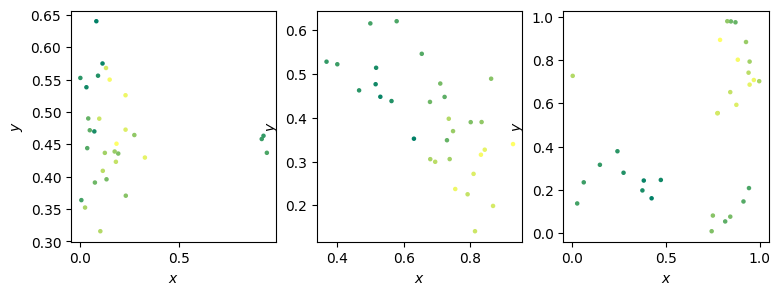

In [6]:
fig, ax = plt.subplots(1,3, figsize=(9,3))

for i,id in enumerate([0,50,100]):
    ax.flatten()[i].set_xlabel('$x$')
    ax.flatten()[i].set_ylabel('$y$')
    ax.flatten()[i].scatter(plankton_dict[id]['x'], plankton_dict[id]['y'], 
                            c=plankton_dict[id]['t'], cmap='summer', s=5)

## Simulating with reproduction

In [45]:
n = 2000 # Starting plankton population size.
iters = 50 # Time steps.
L_max = 1 # Size of square domain.
colour_map = "hsv"

plankton_dict = run_simulation_trajectory(n, iters, L_max, True)

In [46]:
x = []
y = []
y0 = []
t_final = []
for id in plankton_dict:
    x.append(plankton_dict[id]['x'][-1])
    y.append(plankton_dict[id]['y'][-1])
    t_final.append(plankton_dict[id]['t'][-1])
    y0.append(plankton_dict[id]['y0'])

In [47]:
final_idx = np.where(t_final==np.max(t_final))[0]

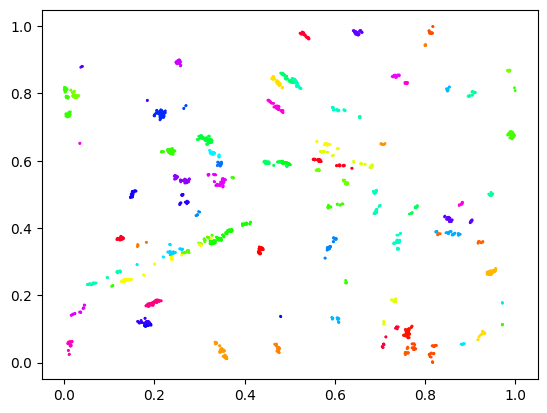

In [48]:
plt.scatter(np.array(x)[final_idx], np.array(y)[final_idx], c=np.array(y0)[final_idx], s=1, cmap=colour_map)
plt.show()

In [49]:
traj_len = []
for id in plankton_dict:
    traj_len.append(len(plankton_dict[id]['x']))
long_traj = np.where(np.array(traj_len)>=10)[0]
long_traj

array([  530,   733,   982,  1296,  2337,  2856,  3059,  3093,  4168,
        4874,  5005,  5188,  6494,  6825,  6859,  7003,  7031,  8128,
        9653, 10325, 10474, 11383, 11517, 11575, 12358, 12496, 12750,
       13711, 14082, 14648, 14724, 15082, 15661, 16274, 17087, 17288,
       17595, 18821, 20562, 21742, 22001, 22151, 23153, 23262, 23302,
       23523, 23825, 24180, 25526, 26208, 27391, 27727, 28244, 28302,
       29022, 29330, 29919, 30390, 30449, 30541, 31672, 31892, 32816,
       33135, 33252, 33949, 34838, 34957, 34986, 35365, 36069, 36521,
       36660, 37783, 38062, 38302, 38782, 38815, 39289, 39639, 39935,
       40120, 42130, 42263, 42267, 44019, 44126, 44407, 44745, 44943,
       45383, 45524, 47477, 47927])

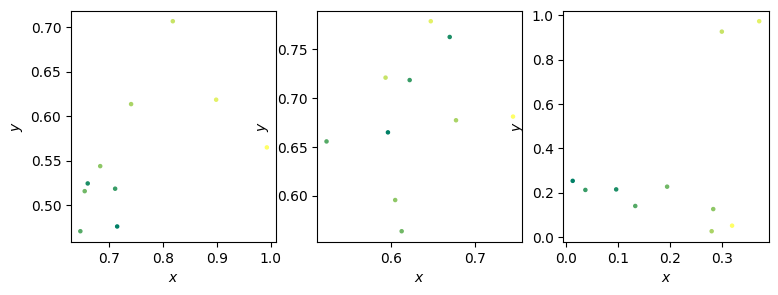

In [50]:
fig, ax = plt.subplots(1,3, figsize=(9,3))

for i,id in enumerate([982,11517,30449]):
    ax.flatten()[i].set_xlabel('$x$')
    ax.flatten()[i].set_ylabel('$y$')
    ax.flatten()[i].scatter(plankton_dict[id]['x'], plankton_dict[id]['y'], 
                            c=plankton_dict[id]['t'], cmap='summer', s=5)

## Decorrelation time of Lagrange velocity

In [38]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]
    
def get_vel_autocorr(id):
    x = plankton_dict[id]['x']
    y = plankton_dict[id]['y']
    
    # Calculate velocity in x direction
    dx = np.diff(x) / 1  # assuming dt is 1
    
    # Calculate velocity in y direction
    dy = np.diff(y) / 1  # assuming dt is 1
    
    # Combine velocities into a single array
    velocity = np.sqrt(dx**2 + dy**2)
    
    # Calculate the autocorrelation function (ACF)

    
    autocorr_velocity = autocorr(velocity)
    lags = np.arange(0, len(velocity))
    return autocorr_velocity, lags

In [39]:
# Define an exponential function
def exponential_func(x, a, b):
    return a * np.exp(b * x)
def fit_exp(lags, autocorr_velocity):
    # Fit the exponential function to the data
    popt, pcov = curve_fit(exponential_func, lags, autocorr_velocity)
    
    # Extract the parameters
    a_fit, b_fit = popt
    return a_fit, b_fit

In [51]:
decorr_time = []
for id in long_traj:
    autocorr_velocity, lags = get_vel_autocorr(id)
    a_fit, b_fit = fit_exp(lags, autocorr_velocity)
    
    # Print the fitted parameters
    #print("a:", a_fit)
    #print("b:", b_fit)
    decorr_time.append(-1/b_fit)
    #print(-1/b_fit)
print("Mean decorrelation time", np.mean(decorr_time))
print("Variance decorrelation time", np.var(decorr_time))

Mean decorrelation time 3.733258478886746
Variance decorrelation time 4.147461713646963


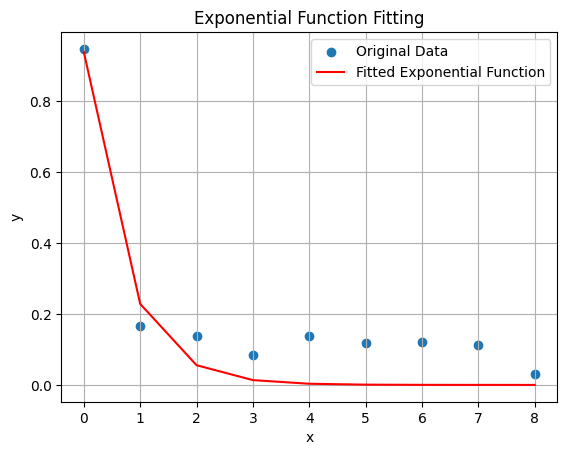

In [52]:
# Plot the original data and the fitted exponential function
plt.scatter(lags, autocorr_velocity, label='Original Data')
plt.plot(lags, exponential_func(lags, a_fit, b_fit), color='red', label='Fitted Exponential Function')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Exponential Function Fitting')
plt.legend()
plt.grid(True)
plt.show()

## extract training data

In [53]:
min_len = 5
traj_len = []

plankton_ids = list(plankton_dict.keys())
for id in plankton_dict:
    traj_len.append(len(plankton_dict[id]['t']))

# plankton ids with min trajectory length
plankton_min = np.where(np.array(traj_len)>=min_len)[0]

In [54]:
def get_coord(id, t):
    x = np.array(plankton_dict[id]['x'])[np.array(plankton_dict[id]['t'])==t]
    y = np.array(plankton_dict[id]['y'])[np.array(plankton_dict[id]['t'])==t]
    return [x,y]

In [55]:
min_len = 5
training_data = []

for i,id1 in enumerate(plankton_min):
    for id2 in plankton_min[i+1:]:
        traj_intersec = set(plankton_dict[id1]['t']).intersection(set(plankton_dict[id2]['t']))
        if (len(traj_intersec) >= min_len):
            #print(id1,id2)
            #print(traj_times[id1], traj_times[id2], traj_intersec)
            traj_intersec = list(traj_intersec)[:min_len] #cutting longer intersections
            t1 = traj_intersec[0] 
            t2 = traj_intersec[-1]
            a1 = get_coord(id1, t1)
            a2 = get_coord(id1, t2)
            b1 = get_coord(id2, t1)
            b2 = get_coord(id2, t2)
            training_data.append((np.array((a1,b1,a2,b2)).squeeze()))

In [56]:
len(training_data)

373847

In [60]:
training_data[0]

array([[0.92807915, 0.61947991],
       [0.4154    , 0.86103146],
       [0.92316518, 0.86910703],
       [0.41359831, 0.61944188]])

In [61]:
np.save('training_data.npy', training_data)